In [1]:
import neuromancer as nm
import torch 
from torch.utils.data import DataLoader
import torch.optim as optim
import os

from dpc_sf.quad_dynamics.eom_dpc import QuadcopterDPC
from dpc_sf.quad_dynamics.eom_pt import QuadcopterPT
from dpc_sf.quad_dynamics.mj import QuadcopterMJ
from dpc_sf.quad_dynamics.params import params
from dpc_sf.quad_dynamics.jac_pt import QuadcopterJac
from dpc_sf.control.trajectory import waypoint_reference
import dpc_sf.gym_environments.multirotor_utils as utils
from dpc_sf.utils.normalisation import normalise_nm, denormalize_nm, normalise_dict
import dpc_sf.utils.pytorch_utils as ptu
from dpc_sf.control.dpc.dpc_utils import generate_data, simulate, get_node, generate_dpc_data
from dpc_sf.utils.random_state import random_state
import numpy as np

from neuromancer.dynamics.ode import ODESystem
from neuromancer.modules.blocks import MLP
from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.dynamics.ode import ode_param_systems_auto as systems
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.dynamics.integrators import Euler, RK4
from neuromancer.callbacks import Callback
from neuromancer.loggers import MLFlowLogger

import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
class Policy(torch.nn.Module):

    def __init__(self, insize, outsize):
        super().__init__()
        self.net = MLP(insize, outsize, bias=True, hsizes=[20, 20, 20])

    def forward(self, x, R):
        features = torch.cat([x, R], dim=-1)
        return self.net(features)

In [3]:
Ts = 0.1
lr = 0.001
logdir = 'test'
epochs = 10
iterations = 3
eval_metric = 'eval_mse'
nsteps = 3
normalize = True
nx = 17
nu = 4

# Sample rollout of true system
# -----------------------------
train_loader, dev_loader, quad = generate_dpc_data(
    Ts=0.1,
    nsteps=3,
    nsim=10, # 10_000
    bs=32,
    quad_type='eom', # 'mj', 'eom'
    normalize=True
)

/Users/vilj909/Code/neuromancer/src/neuromancer/psl/signals.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.nn.functional.softmax(torch.tensor(x)).numpy()


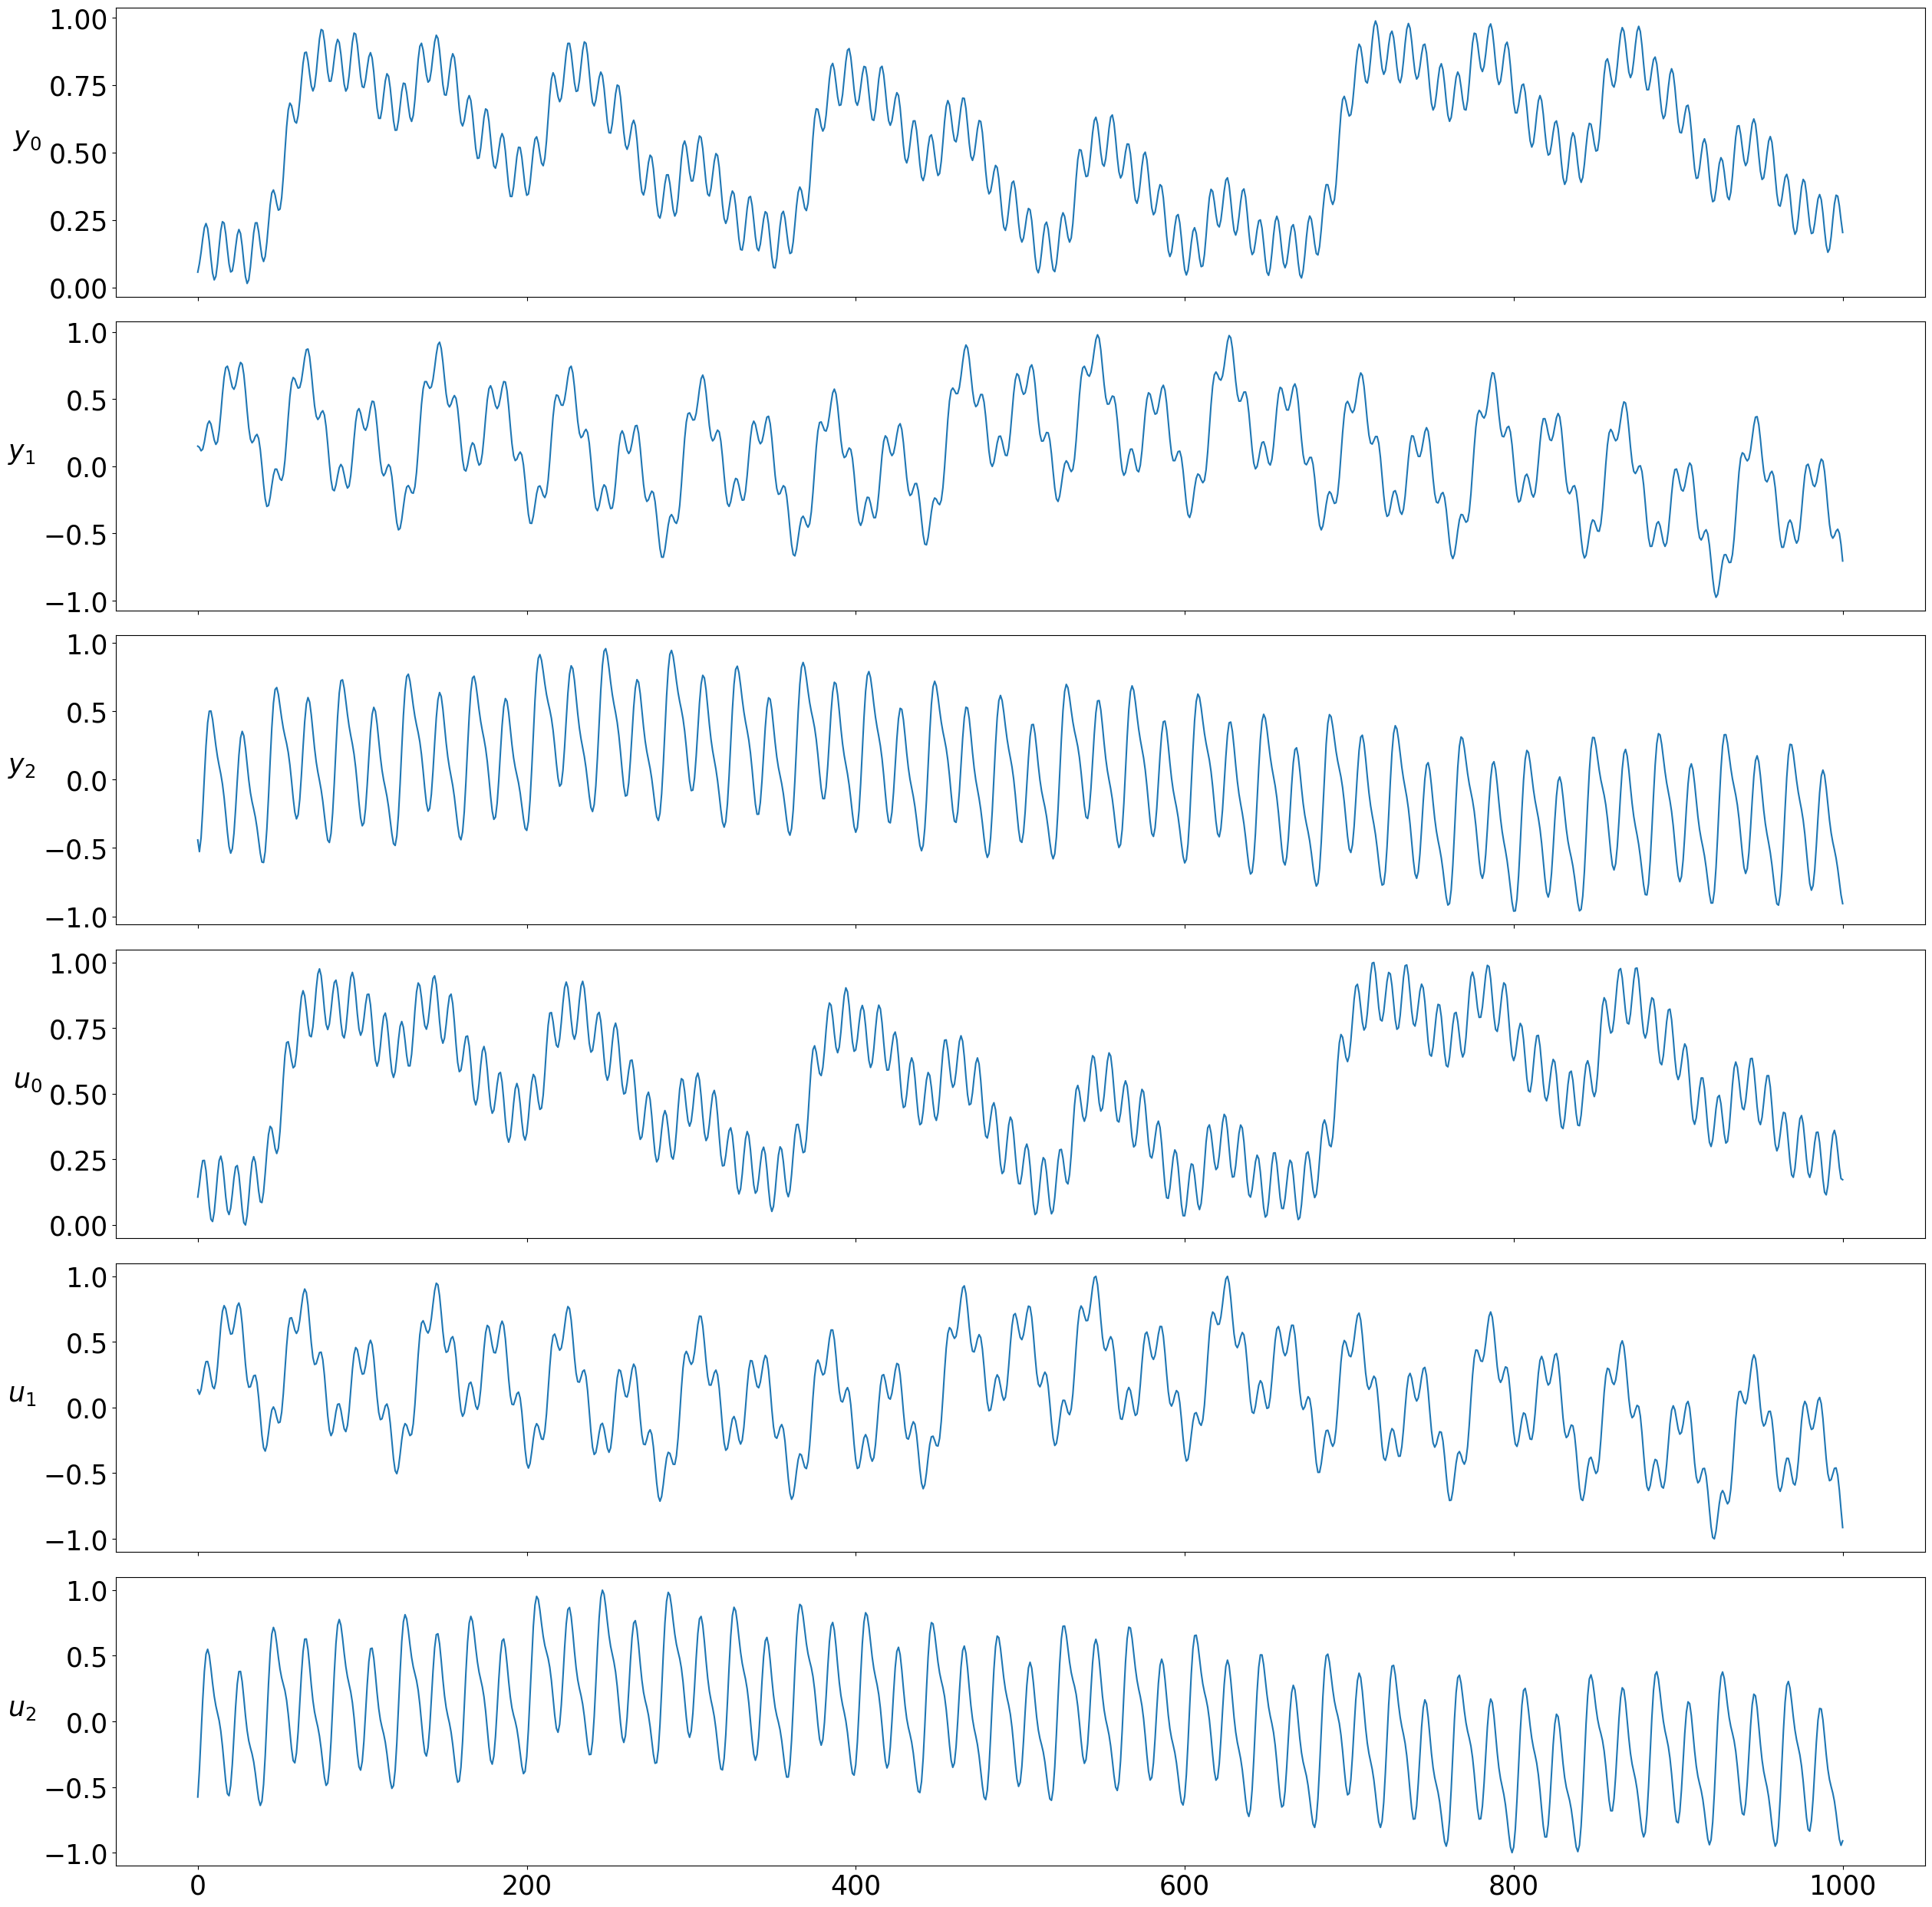

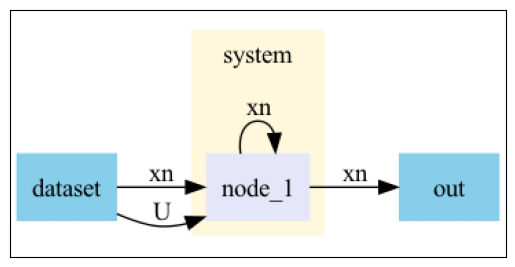

In [6]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
sys = Actuator()
sys.show()
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

dx = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])
interp_u = lambda tq, t, u: u
integrator = integrators.Euler(dx, h=torch.tensor(0.1), interp_u=interp_u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
model = System([system_node])
model.show()

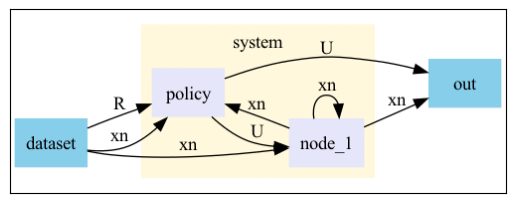

In [19]:
quad = QuadcopterDPC()
insize = 2*nx
policy = Policy(insize, nu)
policy_node = Node(policy, ['xn', 'R'], ['U'], name='policy')
# system_node = get_node(state_dot=quad, ts=Ts)
integrator = integrators.Euler(quad, h=torch.tensor(Ts), interp_u=lambda tq, t, u: u)
system_node = Node(integrator, ['xn', 'U'], ['xn'])
cl_system = System([policy_node, system_node])
System([policy_node, system_node]).show()


In [28]:
cl_system(train_loader.dataset.datadict)['U']

tensor([[[-3.1106e-01,  1.1063e+00,  7.2982e-01,  1.0198e+00],
         [ 4.6212e+00,  8.3867e+01,  5.8632e+01,  4.7731e+01],
         [ 3.0255e+03,  5.9984e+03,  6.3243e+03,  5.2001e+03],
         [ 6.8548e+05,  3.3252e+05,  8.2668e+05,  6.1140e+05],
         [ 1.3494e+08, -8.1926e+06,  1.2773e+08,  8.2530e+07],
         [ 3.1045e+10, -2.0686e+10,  2.0908e+10, -2.0101e+10],
         [-3.1999e+18, -7.2581e+17,  4.8131e+18, -7.2922e+17],
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [        nan,         nan,         nan,         nan],
         [-3.1106e-01,  1.1063e+00,  7.2982e-01,  1.0198e+00],
         [ 4.6212e+00,  8.3867e+01,  5.8632e+01,  4.7731e+01],
         [ 3.0255e+03,  5.9984e+03,  6.3243e+03,  5.2001e+03],
         [ 6.8548e+05,  3.3252e+05,  8.2668e+05,  6.1140e+05],
         [ 1.3494e+08, -8.1926e+06,  1.2773e+08,  8.2530e+07],
         [ 3.1045e+10, -2.0686e+10,  2.0908e+10, -2.010